In [1]:
# imports
import os
import glob
import re
import numpy as np
import cPickle as pickle
from scipy.io import wavfile
from scipy.signal import spectrogram,stft
import matplotlib.pyplot as plt


import librosa
import librosa.display

In [2]:
class piece:
    def __init__(self,filepath, composer, CD):
        self.filepath = filepath
        self.composer = composer
        self.CD = CD

In [3]:
def save_spec(S, savename, savepath, filetype='png'):
    """
    Save melspectrogram as an image
    
    Args:
        S (array): melspectrogram already converted to dBs
        savename (string): name to for file
        savepath (string): path to save to
        filetype (string): file type for image
    """
    
    fig = plt.figure(frameon=False)
    # remove white space
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    # plot spectrogram
    librosa.display.specshow(S,
                         y_axis='mel', fmax=8000,
                         x_axis='time')
    # save
    fig.savefig('{0}/{1}.{2}'.format(savepath, savename, filetype), 
                bbox_inches=None, pad_inches=0)
    plt.close(fig)
    

In [4]:
def prep_melspec(piece, initial_count, dt=30.0):
    """
    Make melscpectogram for a given file
    
    Args:
        filepath (string): path to file
        startpoint (int): number of last image for composer
        dt (float): length of time segment
    """
    # load file
    y, sr = librosa.load('{0}'.format(piece.filepath))
    
    # compute melspectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)
    # conver to db
    S = librosa.power_to_db(S, ref=np.max)
    
    # get time vector
    t = librosa.display.__coord_time(S.shape[1])
    # length of 1s segment
    Lseg = int(1./(t[1]-t[0]))
    # number of segments of length dt
    Nseg = int(S.shape[1]/(dt*Lseg))
    
    count = initial_count
    
    # loop over segements of complete song
    for n in xrange(Nseg):
        start = int(dt*n*Lseg)
        end = int(dt*(n+1.0)*Lseg)
        seg = S[:,start:end]

        
        # save spectrogram
        save_spec(seg, savename = '{0}{1}'.format(piece.composer,count),
                  savepath='./data/data{0}/{1}/'.format(int(dt), piece.composer) )
        # keep track of which file to write
        count +=1
    
    return count

In [5]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

In [9]:
# path to music
musicpath = './data/music/'

# composer and CD
composer = 'chopin'
CD = 'sonatas'

# songs
songpaths = glob.glob('{0}{1}/{2}/*.flac'.format(musicpath, composer, CD))
songnames = [re.split('/|.flac', sp)[-2] for sp in songpaths]

# dictionary that will contain songs
songdict = {}

# length of time segments
dt = 30.0

# check if there is a pre-existing dictionary
if glob.glob('./data/data{0}/{1}/{1}.pkl'.format(int(dt),composer)):
    # load existing dict
    with open('./data/data{0}/{1}/{1}.pkl'.format(int(dt),composer), 'rb') as f:
        old_songdict = pickle.load(f)
else:
    old_songdict = {}

for sp, sn in zip(songpaths, songnames):
    # check if song has already been processed
    if sn in old_songdict:
        # if so, skip
        print('Skipping {0}'.format(sn))
        pass
    else:
        # make spectrogram
        print('Making melspectrogram for: {0}'.format(sn))
        p = piece(sp, composer, CD)
        # check where to start saving images
        initial_count = len(glob.glob('./data/data{0}/{1}/{1}*.png'.format(int(dt),composer)))
        # make melspectrogram and save it
        final_count = prep_melspec(p, initial_count, dt)
        # save start and end of song
        songdict['{0}'.format(sn)] = (initial_count, final_count)

# if dicionary already exists
if old_songdict:
    # merge dicts
    new_songdict = merge_two_dicts(songdict, old_songdict)
    # save upaded dict
    with open('./data/data{0}/{1}/{1}.pkl'.format(int(dt),composer), 'wb') as f:
        pickle.dump(new_songdict, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # create file
    with open('./data/data{0}/{1}/{1}.pkl'.format(int(dt),composer), 'wb') as f:
        pickle.dump(songdict, f, protocol=pickle.HIGHEST_PROTOCOL)

Skipping 01 - Klaviersonate 1.1 Zilberstein 
Skipping 02 - Klaviersonate 1.2 Zilberstein
Skipping 03 - Klaviersonate 1.3 Zilberstein
Skipping 04 - Klaviersonate 1.4 Zilberstein
Skipping 05 - Klaviersonate 2.1 Pollini
Skipping 06 - Klaviersonate 2.2 Pollini
Skipping 07 - Klaviersonate 2.3 Pollini
Skipping 08 - Klaviersonate 2.4 Pollini
Skipping 09 - Klaviersonate 3.1 Pollini
Skipping 10 - Klaviersonate 3.2 Pollini
Skipping 11 - Klaviersonate 3.3 Pollini
Skipping 12 - Klaviersonate 3.4 Pollini


In [14]:
# see what have already been processed
with open('./data/data{0}/{1}/{1}.pkl'.format(int(dt),composer), 'rb') as f:
        current_songdict = pickle.load(f)

for k in current_songdict:
    print(k, current_songdict[k])

('12 - Klaviersonate 3.4 Pollini', (138, 147))
('09 - Klaviersonate 3.1 Pollini', (93, 118))
('02 - Klaviersonate 1.2 Zilberstein', (20, 29))
('05 - Klaviersonate 2.1 Pollini', (49, 63))
('10 - Klaviersonate 3.2 Pollini', (118, 122))
('04 - Klaviersonate 1.4 Zilberstein', (36, 49))
('11 - Klaviersonate 3.3 Pollini', (122, 138))
('01 - Klaviersonate 1.1 Zilberstein ', (0, 20))
('08 - Klaviersonate 2.4 Pollini', (91, 93))
('06 - Klaviersonate 2.2 Pollini', (63, 75))
('03 - Klaviersonate 1.3 Zilberstein', (29, 36))
('07 - Klaviersonate 2.3 Pollini', (75, 91))


In [38]:
# reference plots from here on
# inline from here on
%matplotlib inline

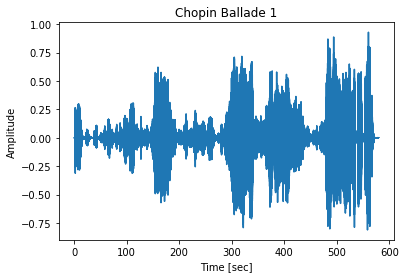

In [10]:
# plot waveform if desired
# duration in sec
T = float(len(y))/sr
# time vector
time = np.arange(0, T, 1./sr)
# plot time series
fig = plt.figure()
plt.plot(time,y)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.title('Chopin Ballade 1')
plt.show()

<IPython.core.display.Javascript object>


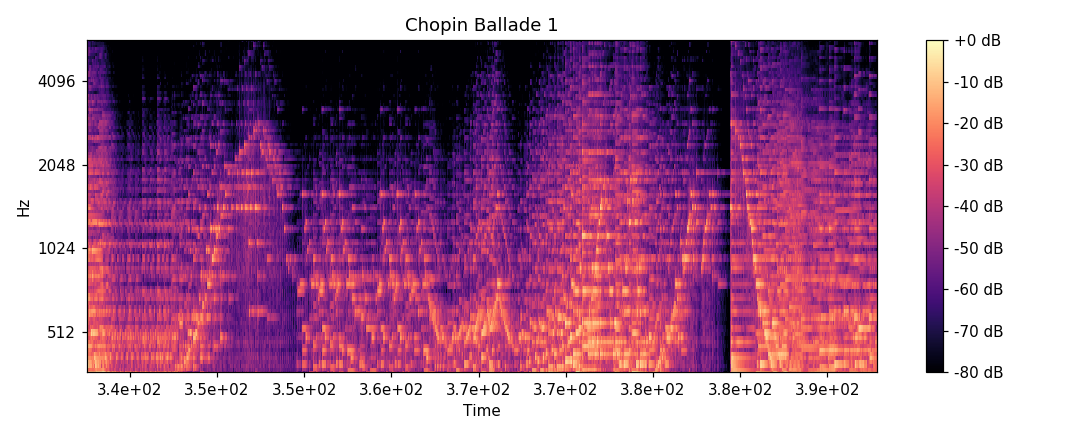

In [21]:
# reference plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(S,
                         y_axis='mel', fmax=8000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Chopin Ballade 1')
plt.tight_layout()